This Jupyter Notebook is meant to be accessed via Google Colab and will be the main method to train models on Google Colab.

In [23]:
# primary importing code block to utilize the python files
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D
from pydub import AudioSegment   # main class from pydub package used to upload mp3 into Python and then get a NumPy array
import IPython.display as ipd    # ability to play audio in Jupyter Notebooks if needed
import librosa as lb             # loads the librosa package
import librosa.display
from src.configs import *
from src.utils import MusicAlignedTab, create_FullSet_df, one_hot_encode, collapse_class, clean_labels
from src.utils import save_drum_tabber_model, load_drum_tabber_model, create_configs_dict
from src.dataset import Dataset
import src.utils as ut

In [ ]:
mat = MusicAlignedTab('mookies_last_christmas')
df = mat.MAT

In [ ]:
df = clean_labels(df)
MusicAlignedTab.labels_summary(df)
df = collapse_class(df, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(df)

In [ ]:
encode_df = one_hot_encode(df)
print(encode_df.columns)
encode_df.head()

In [ ]:
%time targets, target_dict = create_targets(S, encode_df)

In [ ]:
for idx, val in target_dict.items():
    print(f'total windows that {val} are labeled 1 = {np.count_nonzero(targets[idx,:,0])}')
print(f'total windows = {targets.shape[1]}')

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()
plt.imshow(targets[:,:,1])
plt.show()

In [ ]:
MusicAlignedTab.labels_summary(encode_df)

In [ ]:
targets = np.zeros((7, 10, 3), dtype=int)
print(targets.shape)
targets[:, 0, :]

In [ ]:
df.drop(columns = ['song slice', 'sample start'])[df.drop(columns = ['song slice', 'sample start']) != '-'].describe()

In [ ]:
mat.random_alignment_checker(['BD', 'SD', 'CC'], 14)

In [ ]:
librosa.display.specshow(S[:,:,0], sr=44100, x_axis='time', y_axis = 'mel')

### FullSet Testing

In [ ]:
def play(samples, sr=44100):
    '''
    Helper function just so I can type play(samples) to get the song output
    '''
    return ipd.Audio(samples, rate = sr)

In [ ]:
FullSet = create_FullSet_df(SONGS_PATH)
FullSet_clean = clean_labels(FullSet)
MusicAlignedTab.labels_summary(FullSet_clean)
FullSet_collapse = collapse_class(FullSet_clean, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(FullSet_collapse)
FullSet_encoded = one_hot_encode(FullSet_collapse)

In [ ]:
tset = Dataset('train', FullSet_encoded)
vset = Dataset('val', FullSet_encoded)

In [ ]:
song_idx = 1

In [ ]:
%%time
song_df = tset.subset_df.loc[tset.song_list[song_idx]].copy()
song = np.vstack(song_df['song slice'].to_numpy()).T   # stacks the song slices back into a single numpy array of shape (channels, samples)
mono_song = lb.core.to_mono(song)
channels = [mono_song]              # channels is a list of either [mono_song] or [mono, L_song, R_song]
if INCLUDE_LR_CHANNELS:             # appending the LR channels to the channels variable
    channels.append(song[0,:])
    channels.append(song[1,:])
aug_channels = tset.augment_audio_cp(channels, tset.aug_comp, sr=SAMPLE_RATE)

In [24]:
numpysave_fp = 'C:/Users/Thomas/Python Projects/Drum-Tabber-Support-Data/Experimental/'

In [30]:
fy_spec = np.load(numpysave_fp+'fy_spec.npy')
fy_tar = np.load(numpysave_fp+'fy_tar.npy')
mb_spec = np.load(numpysave_fp+'mb_spec.npy')
mb_tar = np.load(numpysave_fp+'mb_tar.npy')
print(mb_spec.shape)

(150, 20804, 3)


<AxesSubplot:xlabel='Time', ylabel='Hz'>

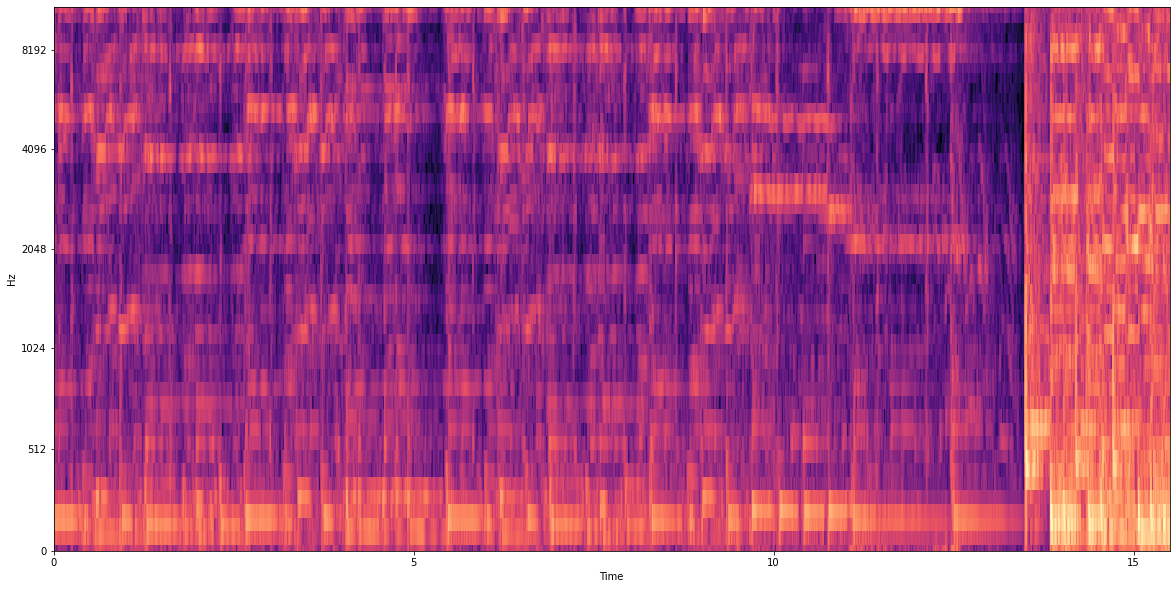

In [56]:
lb.display.specshow(mb_spec[:50,0:1550,0], sr=44100, hop_length=441,
                    x_axis = 'time' , y_axis = 'mel')

In [ ]:
m,n = 20,7
prob = 0.05
rand_labels = (np.random.rand(m,n) <= prob).astype(np.int)
rand_logits = np.random.rand(m,n)
weigh =  np.array([prob for _ in range (n)], dtype=np.float32)
print(rand_labels)
print(rand_logits)
print(weigh, weigh.shape)


losses = tf.nn.weighted_cross_entropy_with_logits(labels = rand_labels.astype(np.float32),
                                                logits = tf.dtypes.cast(rand_logits, np.float32),
                                                 pos_weight = weigh)
print(losses)

## Testing of the train.py

In [1]:
from train import *
main()

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


...Concatenating all music-aligned dataframes
...Replacing NaNs with - for output
---dataframe.describe() without blank_chars---
           tk     BD    SD    HH    RD    CC    C2   LT   MT   HT  CH   C3  SC
count   49917  11829  7624  5388  1718  3279  2334  994  391  298  97  302  26
unique      9      3     8     9     5     4     4    5    4    4   3    3   2
top         +      o     o     x     x     X     X    o    o    o   X    X   X
freq    12461  11356  6527  2905  1090  2016  1891  888  315  249  81  264  20

---Unique values and frequencies by column name---
        +      e      a     1     2     3     4   t   s
tk  12461  12459  12446  3206  3202  3199  2867  47  30

        -      o    O   d
BD  38088  11356  430  43

        -     o    g    O    f   d   r   x  0
SD  42293  6527  527  271  136  75  73  14  1

        -     x     X    o   O   s   g  S  d  w
HH  44529  2905  2186  195  35  32  26  5  2  2

        -     x    X    b   g   f
RD  48199  1090  476  113  25  14


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


---dataframe.describe() without blank_chars---
           tk     BD    SD    HH    at    ac
count   12474  11829  7024  2907  1540  9801
unique      2      1     1     1     1     1
top         c      o     o     x     o     x
freq     9268  11829  7024  2907  1540  9801

---Unique values and frequencies by column name---
        -     c     C
tk  37443  9268  3206

        -      o
BD  38088  11829

        -     o
SD  42893  7024

        -     x
HH  47010  2907

        -     o
at  48377  1540

        -     x
ac  40116  9801

one_hot_encode: col_list before encoding = ['tk', 'BD', 'SD', 'HH', 'at', 'ac']
one_hot_encode: col_list after encoding = ['song slice', 'sample start', 'tk_beat', 'tk_downbeat', 'BD_o', 'SD_o', 'HH_x', 'at_o', 'ac_x']
train.py main(): FullSet_encoded created!
train.py main():  [0.03895392 0.00999018 0.03704841 0.02174556 0.00904216 0.00440068
 0.03095268]
train.py main(): drum_tabber model created!
Model: "model"
______________________________________________

Epoch: 4 Song  8/23, lr:0.000097, song_loss:1.193458
Epoch: 4 Song  9/23, lr:0.000097, song_loss:1.350813
Epoch: 4 Song 10/23, lr:0.000097, song_loss:1.210677
Epoch: 4 Song 11/23, lr:0.000097, song_loss:1.016923
Epoch: 4 Song 12/23, lr:0.000097, song_loss:1.336399
Epoch: 4 Song 13/23, lr:0.000097, song_loss:0.939326
Epoch: 4 Song 14/23, lr:0.000096, song_loss:1.096974
Epoch: 4 Song 15/23, lr:0.000096, song_loss:1.452196
Epoch: 4 Song 16/23, lr:0.000096, song_loss:0.936244
Epoch: 4 Song 17/23, lr:0.000096, song_loss:1.245173
Epoch: 4 Song 18/23, lr:0.000095, song_loss:1.283024
Epoch: 4 Song 19/23, lr:0.000095, song_loss:1.100200
Epoch: 4 Song 20/23, lr:0.000095, song_loss:1.160717
Epoch: 4 Song 21/23, lr:0.000095, song_loss:1.032606
Epoch: 4 Song 22/23, lr:0.000095, song_loss:1.221856
Epoch: 4 Song 23/23, lr:0.000094, song_loss:1.714363


Epoch:  4 val_loss:1.348607 


Starting Epoch 5/15
Epoch: 5 Song  1/23, lr:0.000094, song_loss:1.159967
Epoch: 5 Song  2/23, lr:0.000094, song_loss:1.

Epoch:10 Song 19/23, lr:0.000035, song_loss:1.022993
Epoch:10 Song 20/23, lr:0.000034, song_loss:1.021967
Epoch:10 Song 21/23, lr:0.000034, song_loss:1.068353
Epoch:10 Song 22/23, lr:0.000033, song_loss:1.083253
Epoch:10 Song 23/23, lr:0.000033, song_loss:1.085611


Epoch: 10 val_loss:1.195925 


Starting Epoch 11/15
Epoch:11 Song  1/23, lr:0.000032, song_loss:1.372977
Epoch:11 Song  2/23, lr:0.000032, song_loss:1.249202
Epoch:11 Song  3/23, lr:0.000031, song_loss:1.202454
Epoch:11 Song  4/23, lr:0.000031, song_loss:1.060992
Epoch:11 Song  5/23, lr:0.000031, song_loss:1.392942
Epoch:11 Song  6/23, lr:0.000030, song_loss:1.432312
Epoch:11 Song  7/23, lr:0.000030, song_loss:1.162862
Epoch:11 Song  8/23, lr:0.000029, song_loss:1.268629
Epoch:11 Song  9/23, lr:0.000029, song_loss:0.969693
Epoch:11 Song 10/23, lr:0.000028, song_loss:1.177494
Epoch:11 Song 11/23, lr:0.000028, song_loss:1.019869
Epoch:11 Song 12/23, lr:0.000027, song_loss:1.367290
Epoch:11 Song 13/23, lr:0.000027, song_loss:1

### Loading back in a saved model, configs_dict, and sample song

In [4]:
# load a model back in 
model_to_load_name = 'Context-CNN-E15-VL1_17991'
loaded_model, loaded_configs = load_drum_tabber_model(model_to_load_name, SAVED_MODELS_PATH)
print(loaded_configs)

{'class_names_dict': {'0': 'tk_beat', '1': 'tk_downbeat', '2': 'BD_o', '3': 'SD_o', '4': 'HH_x', '5': 'at_o', '6': 'ac_x'}, 'num_classes': 7, 'num_features': 100, 'num_channels': 1, 'n_mels': 100, 'model_type': 'Context-CNN', 'window_size': 2048, 'hop_size': 441, 'shift_to_db': True, 'n_context_pre': 13, 'n_context_post': 13, 'include_fo_differential': False, 'positive_window_fraction': 0.3, 'negative_window_fraction': 0.1, 'classification_dict': {'clean_date': True, 'keep_dynamics': False, 'keep_bells': False, 'keep_toms_seperate': False, 'hihat_classes': 1, 'cymbal_classes': 1}, 'month_date': '-Nov-11'}


In [5]:
# load sample song and make spectrogram
song_to_test = 'four_years'
samp_song, sr_song = lb.core.load(os.path.join(SONGS_PATH,song_to_test,song_to_test+'.mp3'), sr=None, mono=True)
print(f'Number of samples in song is {samp_song.shape[0]}')
spectro = lb.feature.melspectrogram(np.asfortranarray(samp_song), sr = sr_song, n_fft=loaded_configs['window_size'], hop_length = loaded_configs['hop_size'], center = False, n_mels = loaded_configs['n_mels'])
if loaded_configs['shift_to_db']:
    spectro = lb.power_to_db(spectro, ref = np.max)
spectro_norm = (spectro - spectro.mean())/spectro.std()
spectrogram = spectro_norm.copy()
n_features, n_windows = spectrogram.shape
print(f'spectrogram shape is {spectrogram.shape}')
if loaded_configs['model_type'] == 'Context-CNN':

    pre_context, post_context = loaded_configs['n_context_pre'], loaded_configs['n_context_post']
    input_width = pre_context + 1 + post_context
    min_value = np.min(spectrogram)

    # assign into this np.array filled with the min values of the spectrogram (silence)
    input_array = np.full(shape = (n_windows, n_features, input_width), fill_value = min_value)

    for idx in range(n_windows):
        if idx - pre_context < 0:    # in a window where you would slice before the beginning
            start = pre_context-idx
            input_array[idx, :, start:] = spectrogram[:, 0:idx+post_context+1]
        elif idx + post_context+1 > n_windows: # in a window where you would slice past the end
            end = post_context+1 - (n_windows - idx)
            input_array[idx, :, :input_width-end] = spectrogram[:, idx-pre_context: n_windows ]
        else:    # in a "normal" middle window where you slice into the spectrogram normally
            input_array[idx, :,:] = spectrogram[:, idx-pre_context : idx+post_context+1]

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Number of samples in song is 11265408
spectrogram shape is (100, 25541)


In [16]:
# making predictions on the sample song
start_ind = 0
end_ind = start_ind + 4096
%time predictions = loaded_model(np.expand_dims(input_array,axis=-1)[start_ind:end_ind,:,:,:], training=False)
print(predictions.shape)

Wall time: 13.9 s
(4096, 7)


In [149]:
predictions.numpy().shape

(4096, 7)

[ 12  22  82  94 128 198 246 292 375 395 410 446 479]


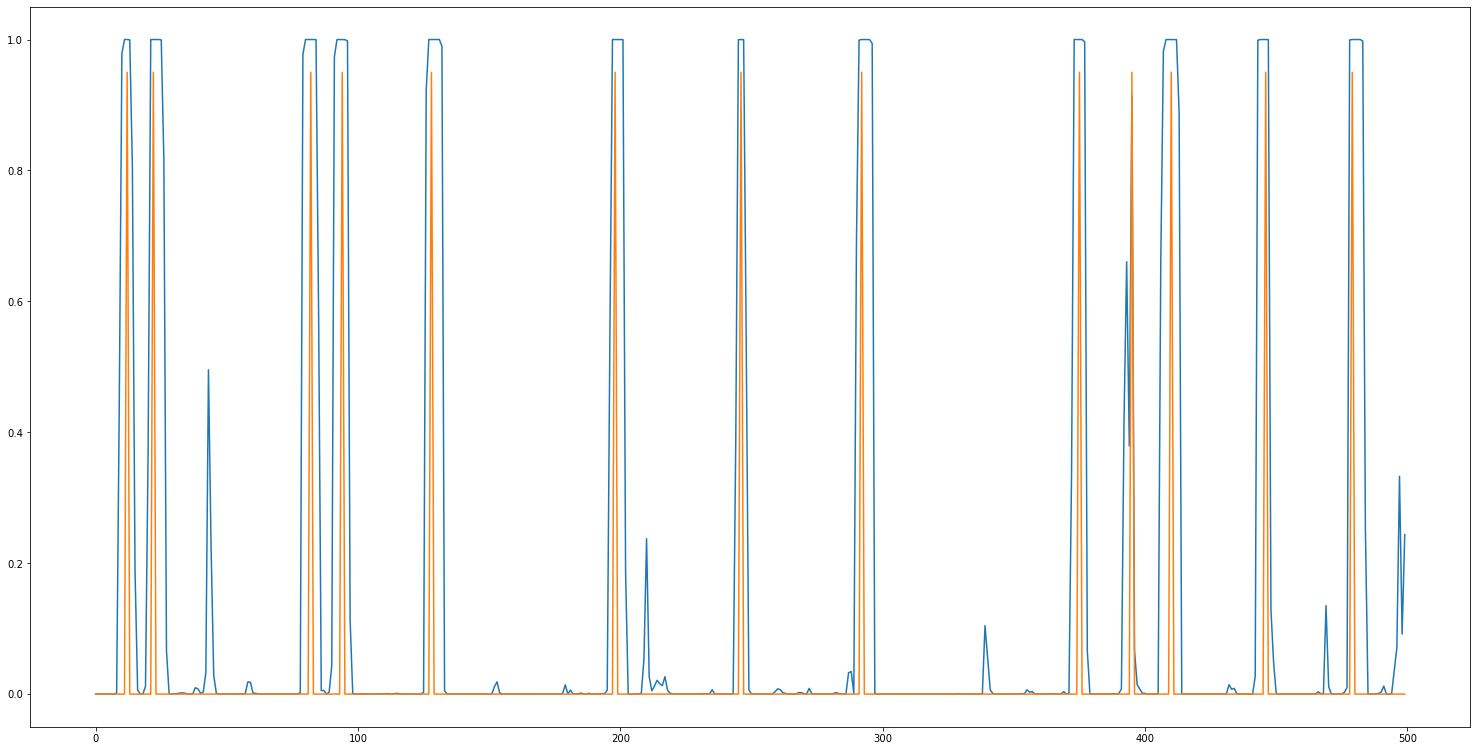

In [153]:
idx = 2
diff_samples = 500
start = 1000
end = start + diff_samples
pred = predictions[start:end,idx].numpy()
pred_peaks = np.zeros(shape = pred.shape)

pred_peaks_idx = lb.util.peak_pick(x = pred, pre_max = 2, post_max = 2, pre_avg = 20, post_avg = 20, 
                              delta = 0.5, wait = 5)
print(pred_peaks_idx)
pred_peaks[pred_peaks_idx] = 0.95

# making a plot to output
plt.rcParams["figure.figsize"]=20,10
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(pred)
ax.plot(pred_peaks)
#ax.vlines(pred_peaks_idx, ymin=0, ymax=1, colors='r', alpha=0.8)


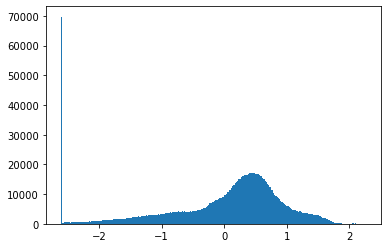

In [16]:
_ = plt.hist(spectrogram.flatten(), bins='auto')
plt.show()

In [ ]:
plt.hist(lb.feature.delta(data = normed_fy, width=9, order=1, axis=-1).flatten(), bins='auto')

In [ ]:
fy_ftd = lb.feature.delta(data = fy, width=9, order = 1, axis=-1)
_ = plt.hist(fy_ftd.flatten(), bins='auto')
plt.show()